In [1]:
 # These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../../..")
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu"

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib notebook

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Model definition

Same problem as before, let's assume the observations are layer thickness measurements taken on an outcrop. Now, in the previous example we chose a prior for the mean arbitrarily: $𝜇∼Normal(mu=10.0, sigma=5.0)$--something that made sense for these especific data set. If we do not have any further information, keeping an uninformative prior and let the data to dictate the final value of the inference is the sensible way forward. However, this also enable to add information to the system by setting informative priors.

Imagine we get a borehole with the tops of the two interfaces of interest. Each of this data point will be a random variable itself since the accuracy of the exact 3D location will be always limited. Notice that this two data points refer to depth not to thickness--the unit of the rest of the observations. Therefore, the first step would be to perform a transformation of the parameters into the observations space. Naturally in this example a simple substraction will suffice.

Now we can define the probabilistic models:

In [2]:
with pm.Model() as model:
    r2 = pm.Normal('depth 2', -50, 5)
    r1 = pm.Normal('depth 1', -40, 5)
   
    mu = pm.Deterministic('$\mu$', r2-r1)
    sigma = pm.Gamma('$\sigma$', 1, .7)

    y = pm.Normal('y', mu=mu, sd=sigma, observed=[7, 6, 5, 6, 6, 6.2, 5, 15])


In [3]:
r2

depth 2

In [4]:
r1

depth 1

In [5]:
mu

$\mu$

In [6]:
sigma

$\sigma$

In [7]:
y

y

## Sampling

In [8]:
with model:
    prior = pm.sample_prior_predictive(1000)
    trace = pm.sample(1000)
    post = pm.sample_posterior_predictive(trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\sigma$, depth 1, depth 2]
100%|██████████| 4000/4000 [00:02<00:00, 1764.93it/s]


In [9]:
import arviz as az

data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=post)
data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

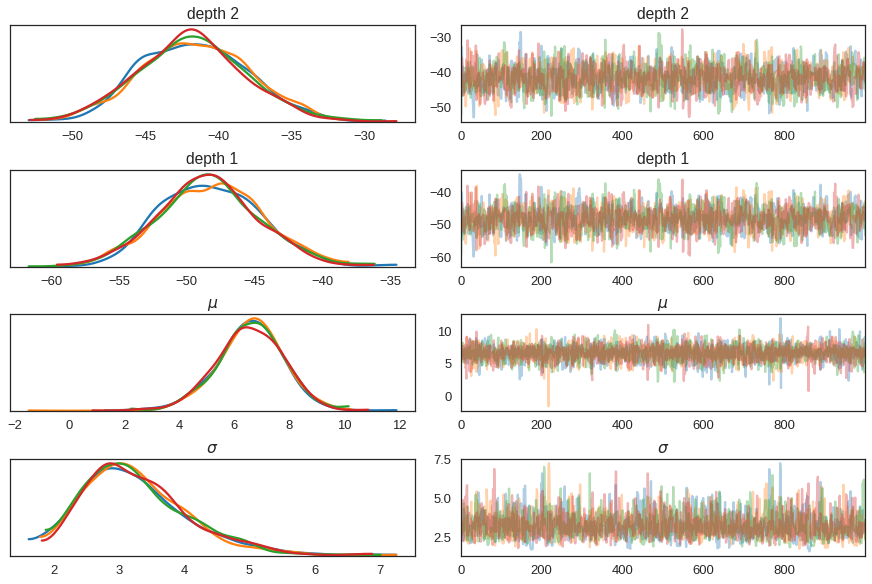

In [10]:
az.plot_trace(data);

In [11]:
# !git pull
from gempy.bayesian import plot_posterior as pp

import seaborn as sns


<IPython.core.display.Javascript object>


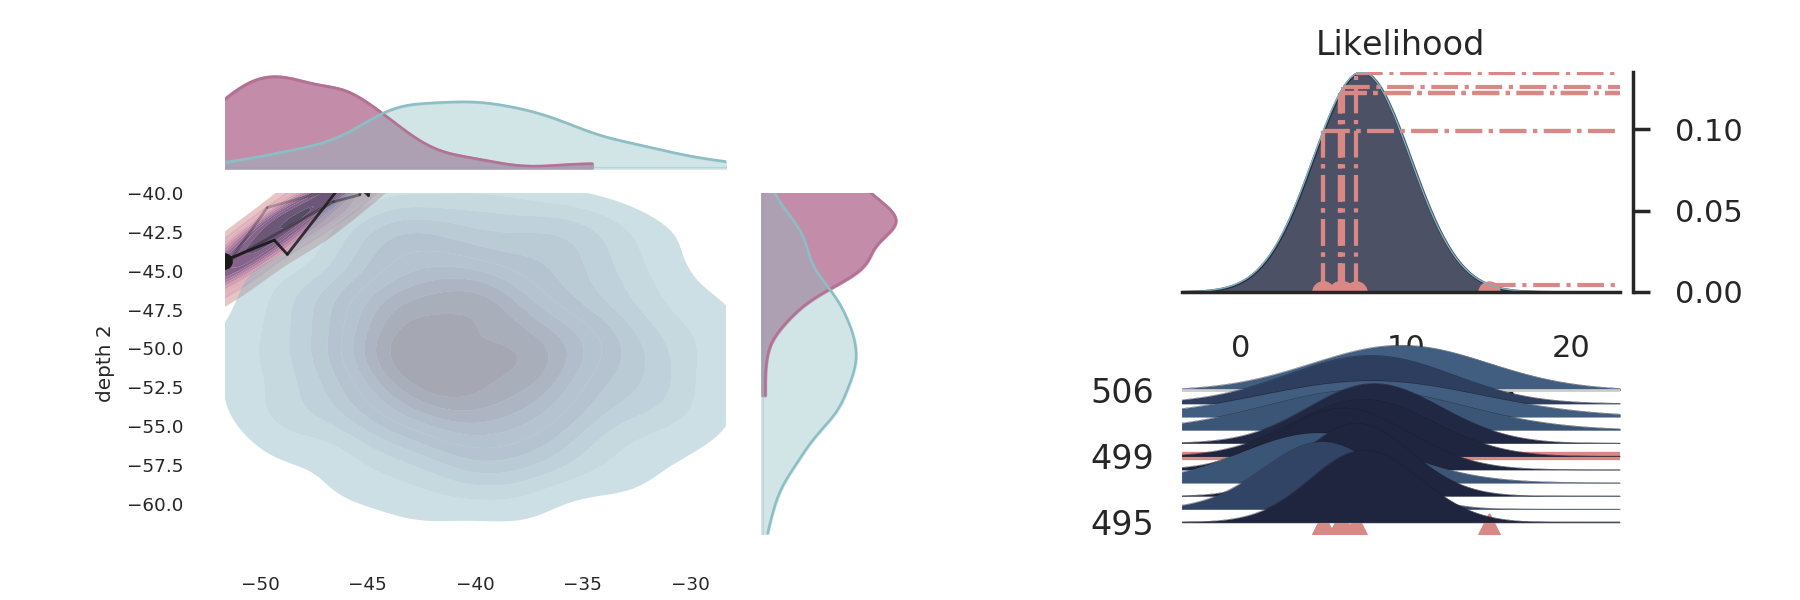

In [12]:
%matplotlib notebook
from importlib import reload
reload(pp)
p = pp.PlotPosterior(data)
p.create_figure(figsize=(9,3), joyplot=True)

In [13]:
def change_iteration(iteration):
    p.plot_posterior(['depth 1', 'depth 2'], ['$\mu$', '$\sigma$'], 'y', iteration)
    # p.plot_posterior(['$\mu$', '$\sigma$'], ['$\mu$', '$\sigma$'], 'y', iteration)

In [14]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(change_iteration, iteration=(0, 1000, 1))

interactive(children=(IntSlider(value=500, description='iteration', max=1000), Output()), _dom_classes=('widge…

<function __main__.change_iteration(iteration)>

In [15]:
from gempy.bayesian.plot_posterior import my_cmap_full

<IPython.core.display.Javascript object>


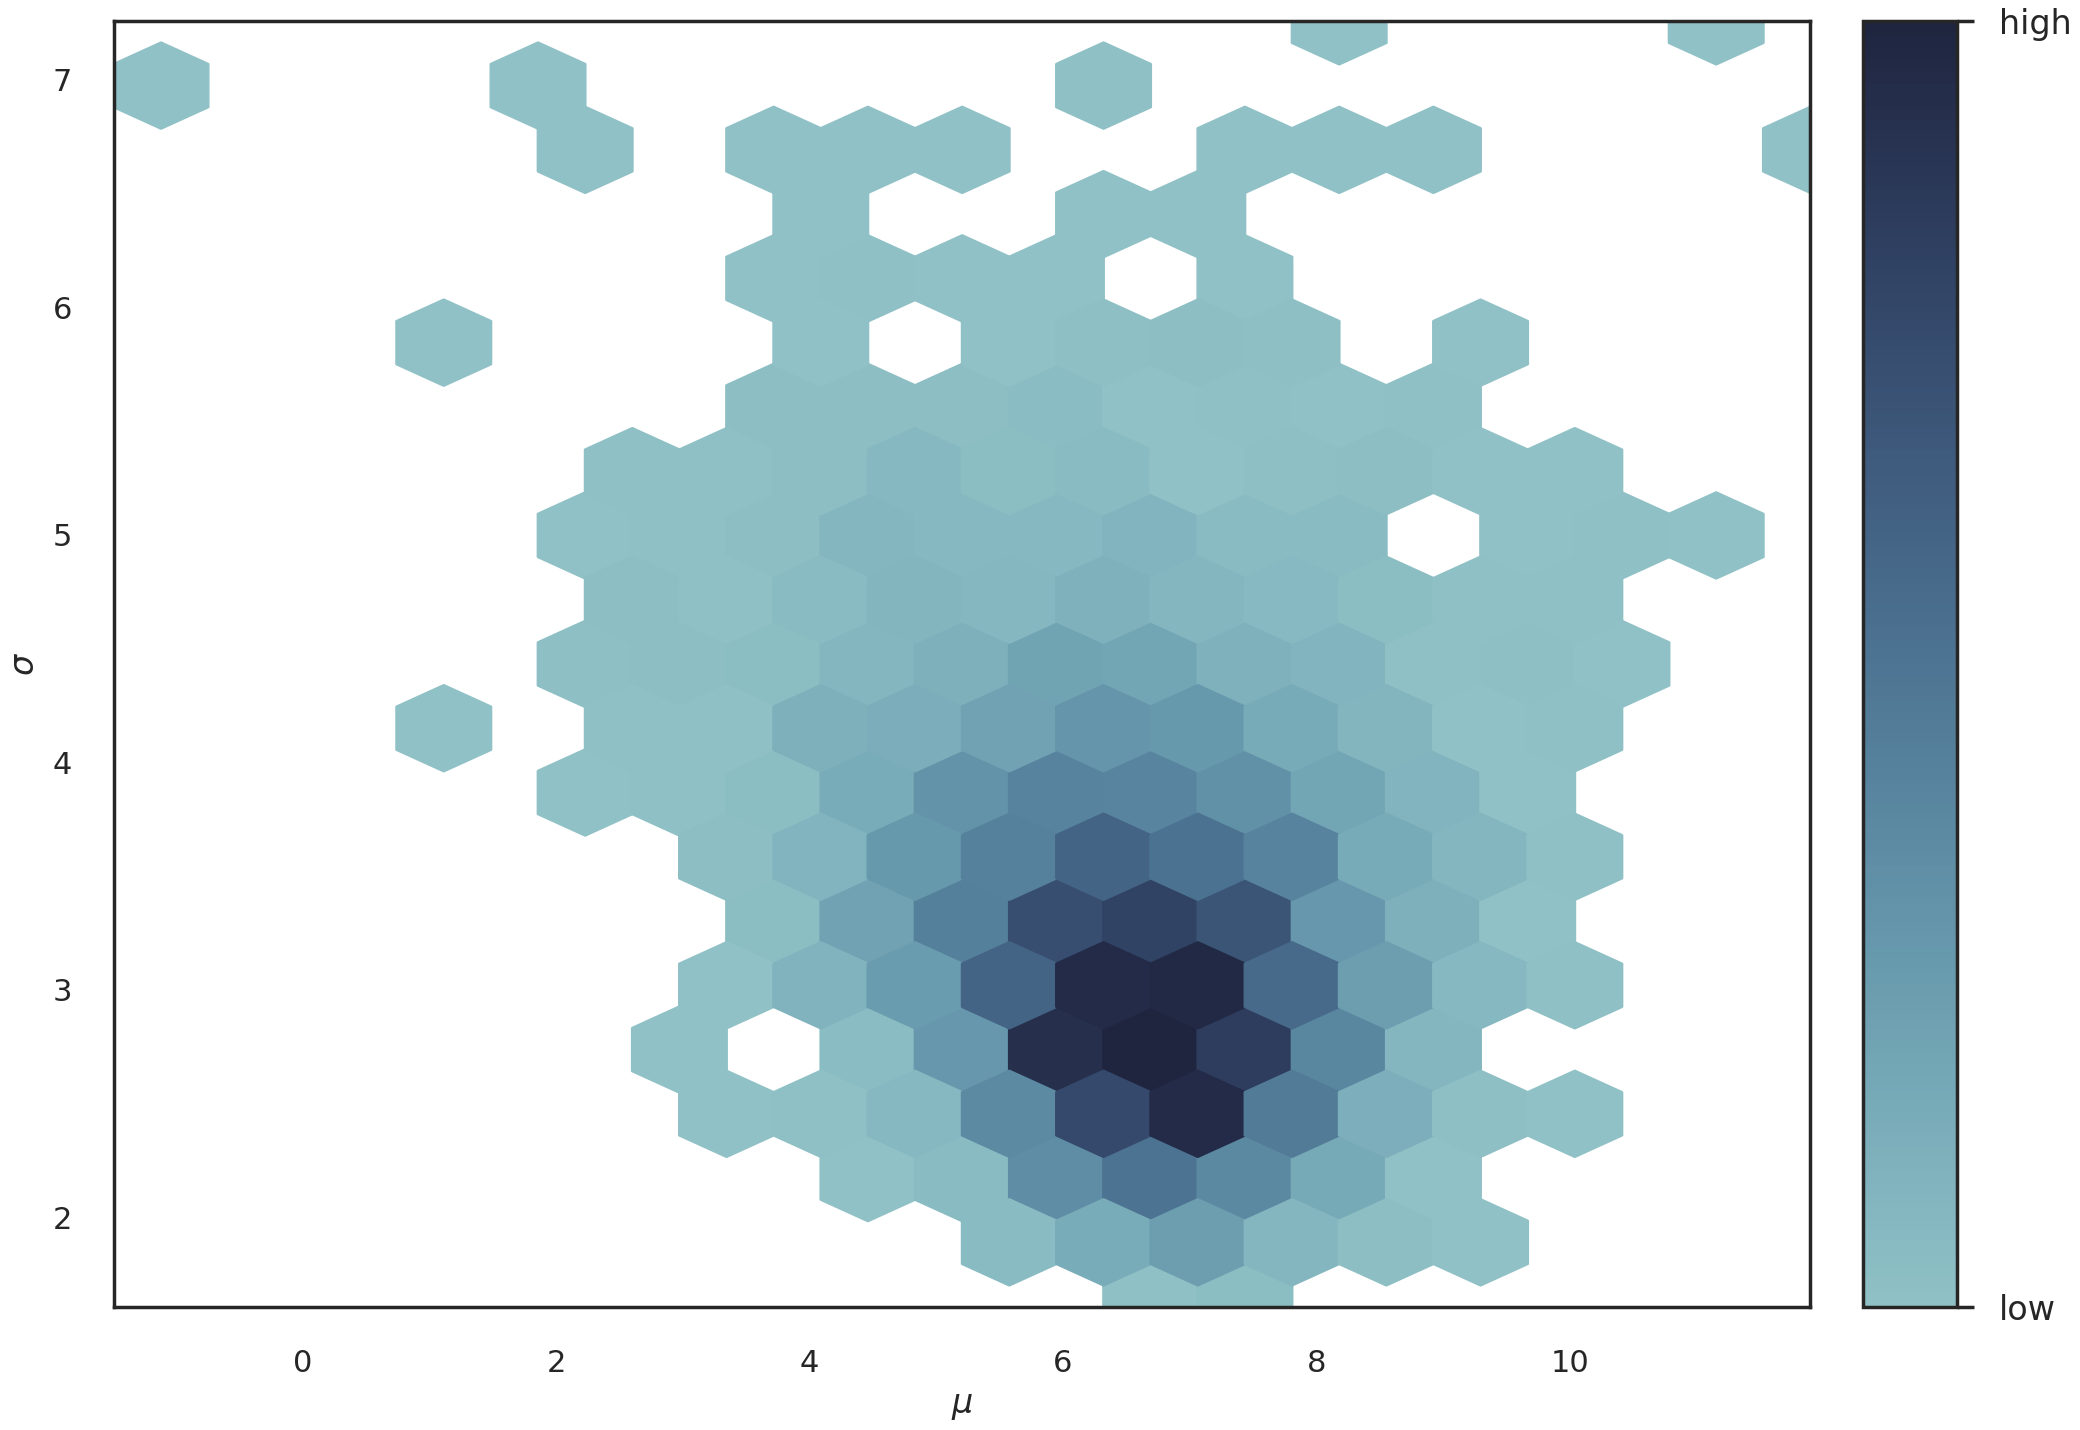

In [16]:
az.plot_pair(data, divergences=True, var_names=['$\mu$', '$\sigma$', '$y$'], kind='hexbin', contour=True,
            colorbar=True, plot_kwargs={'cmap':my_cmap_full});